$$
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}
\newcommand{\indic}{\mathbb{1}}
\newcommand{\avg}{\overline}
\newcommand{\est}{\hat}
\newcommand{\trueval}[1]{#1^{*}}
\newcommand{\Gam}[1]{\mathrm{Gamma}#1}
$$

$$
\renewcommand{\like}{\cal L}
\renewcommand{\loglike}{\ell}
\renewcommand{\err}{\cal E}
\renewcommand{\dat}{\cal D}
\renewcommand{\hyp}{\cal H}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{\mathbf x}
\renewcommand{\v}[1]{\mathbf #1}
$$

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


plt.rcParams['figure.figsize'] = (12,6)

In this notebook, we will illustrate how to sample from a Markov chain and introduce two MCMC algorithms: Metropolis-Hastings and Gibbs sampling. The notes was written based on two sources:

1. Introduction to Probability, Blitzstein et. al.
2. An Introduction to MCMC for Machine Learning, C. Andrieu, et. al.


# Markov chain sampling

Suppose we want to simulate the following Markov chain

![a markov chain](gfx/amarkovchain.jpg)

with transition matrix:

![transition matrix](gfx/transm.jpg)

In [5]:
# transition matrix
Q = np.array([[1/3, 1/3, 1/3, 0], [0,0,1/2,1/2], [0,1,0,0],[1/2,0,0,1/2]])

# number of states
M = Q.shape[0]

# number of simulation
nsim = 10**4

# storing the result of simulation
x = np.zeros(nsim, dtype=int)

# seed
np.random.seed(2017)

# pickuniformly an intial state
x[0] = np.random.choice(np.arange(M), size=1)

# sampling from the Markov chain
for i in range(1,nsim):
    x[i] = np.random.choice(np.arange(M), size=1, p=Q[x[i-1]])

Since we set nsim to a large number, it may be reasonble to believe that the chain is close to stationary during the latter portion of simulation. To check this, we eliminate the first haft of the simulations to give the chain time to reach stationary

In [6]:
samples = x[nsim//2:nsim]

In [7]:
elements, counts = np.unique(samples, return_counts=True)

Normalize them we have an approximiation to the stationary distribution

In [8]:
counts/sum(counts)

array([0.2088, 0.2924, 0.2234, 0.2754])

Note that the true stationary distribution for this Markov chain is (3/14, 2/7, 3/14, 2/7)

In [9]:
[3/14, 2/7, 3/14, 2/7]

[0.21428571428571427,
 0.2857142857142857,
 0.21428571428571427,
 0.2857142857142857]

We can see that the our sampling distribution is quite close to the true **stationary distribution**.

In Bayesian statistics, a lot of times we want to peform sampling from a complex distribution which is difficult to deal with. The difficulty arises in evaluating integration to compute the normalization factor. 

To address this problem, we construct a Markov chain whose stationary distribution is the original distribution that we want to sample from. Since sampling from Markov chain is easy, we can peform sampling from the constructed Markov chain. 

And because the stationary distribution of the constructed Markov chain is the original distribution, this means if we run the Markov chain long enough, samples from the Markov chain will be samples from the orignal distribution, at least approximately.

### Markov chain in continous state space

The transition matrix is only good for the case of finite state space. In the case of continous state space, the transition matrix T becomes an integral kernel $K$ and $p(x)$ becomes the corresponding eigenfunction

$$\int p(x^{(i)})K(x^{(i+1)}| x^{(i)})dx^{(i)} = p(x^{(i+1)})$$

The kernel $K$ is the conditional density of $x^{(i+1)}$ given the value $x^{(i)}$. It is a mathematical representation of a Markov chain algorithm.



## Metropolis-Hastings

The Metropolis-Hasting algorithm is a general recipe that lets us start with any irreducible Markov chain on the state space of interest and then modify it into a new Markov chain that has desired stationary distribution

Our goal is to modify a MC P to construct a MC $X_0, X_1, \dots$ with stationary distribution $s$. The pseudocode is as follows.

1. Start at any state $X_0$ (choosen randomly or deterministically)
2. If $X_n = i$, propose a new state j using the transition probabilities in the ith row of the original transition matrix P.
3. Compute the acceptance probability $a_{ij} = min(\frac{s_jp_{ij}}{s_ip_{ij}},1)$
4. Flip a coin that lands Heads with probability $a_{ij}$
5. If the coin lands Heads, accept the proposal (i.e., go to j) setting $X_{n+1} = j$. Otherwise, reject the proposal (i.e., stay at i), setting $X_{n+1} = i$.

The Metropolis-Hastings algorithm can slo be applied in a continous state space, using pdfs instead of pmfs. This is veery useufl in Bayesian inference, where we oftwent want to study **the posterior distribution** of an unknown parameter. This posterior distribution maybe very complicated to work with analytically, and may have an unknown normalizing constant. 

The MCMC approach is to obtain a large number of draws fromo a Markov chain whose stationary distribution is the posterior distribution. We can then use these draws to approximate the true posterior distribution. For example, we can estimate the posterior mean using the sample mean of these draws.

## An example: Normal-Normal conjugacy

Let $Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$, where $\sigma^2$ is known but $\theta$ is unknown.

Using Bayesian framework, we treat $\theta$ as a random variable, with prior given by $\theta \sim \cal{N}(\mu, \tau^2)$ for some known constants $\mu$ and $\sigma^2$. That is, we have a two level model 
$$\theta \sim \cal{N}(\mu, \tau^2)\\ Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$$

We will use the Metropolis-Hastings algorithm to find the posterior mean and variance of $\theta$ after observing the value of $Y$.

After observing Y = y, we have $f_{\theta \mid y}(\theta \mid y) \propto f_{y\mid \theta}(y \mid \theta)f_{\theta}(\theta) \propto e^{-\frac{1}{2\sigma^2}(y-\theta)^2}e^{-\frac{1}{2\tau^2}(\theta-\mu)^2}$. 

By completing square, we can obtain an explitie formula for the posterior distribution of $\theta$:

![normal normal](gfx/normal_normal.jpg)

Suppose that we didn't know how to complete the square (we do not have the above formula). Or we just simply want to verify our formula for a specific values of $y, \sigma^2, \mu, \tau^2$. We can do this by simulating from the posteior distribution of $\theta$, using the Metropolis-Hastings algorithm to construct a Markov chain whose stationary distribution is $f_{\theta \mid y}(\theta \mid y)$.

A Metropolis-Hastings algorithm for generating $\theta_0, \theta_1, \ldots$ is as follows.


### Metropolis

1. Use a proposall distribution to propose a step
2. Calculuate the pdf at that step, and compare it to the one at previous step
3. If the probability increased we accept, if the probability decreased we accept some of the time, based on the ratio of the new probability to the old one.
4. Accumulate samples

In [57]:
def metropolis(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        # new proposal x*
        x_star = qdraw(x_prev)
        
        # p(x*)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
        else: # we always get a sample
            samples[i] = x_prev
    return samples

In [62]:
def metropolis2(p, qdraw, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    for i in range(nsamp):
        # new proposal x*
        x_star = qdraw(x_prev)
        
        # p(x*)
        p_star = p(x_star)
        p_prev = p(x_prev)
        
        if (p_star > p_prev):
            samples[i] = x_star
            x_prev = x_star
        else:
            pdfratio = p_star/p_prev
            if np.random.uniform() < pdfratio:
                samples[i] = x_star
                x_prev = x_star
            else:
                samples[i] = x_prev
    return samples

Now we can samples from a Gaussian distribution

In [58]:
from scipy.stats import uniform
def propmaker(delta):
    rv = uniform(-delta, 2*delta)
    return rv
uni = propmaker(0.5)
def uniprop(xprev):
    return xprev+uni.rvs()

starting point was  0


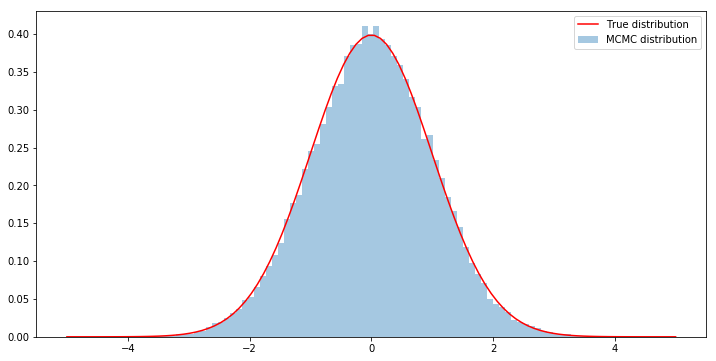

In [69]:
samps = metropolis(norm.pdf, uniprop, 100000, 0.0)
plt.hist(samps,bins=80, alpha=0.4, label=u'MCMC distribution', normed=True); 
#plot the true function
xxx= np.linspace(-5,5,100)
plt.plot(xxx, norm.pdf(xxx), 'r', label=u'True distribution') 
plt.legend()
print("starting point was ", 0)

In [67]:
# samps = metropolis(norm.pdf, uniprop, 100000, 0.0)
samps = metropolis2(norm.pdf, uniprop, 100000, 100)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


starting point was  100


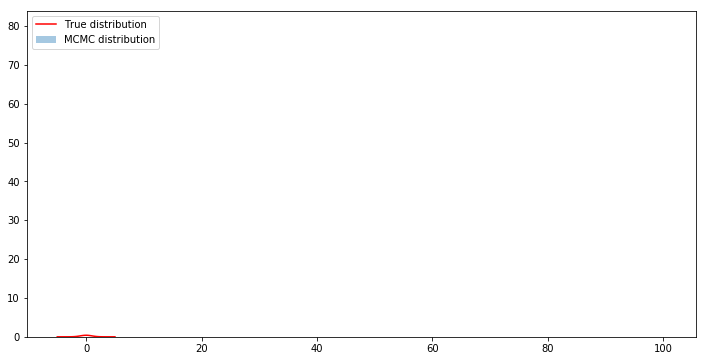

In [68]:
plt.hist(samps,bins=80, alpha=0.4, label=u'MCMC distribution', normed=True); 
#plot the true function
xxx= np.linspace(-5,5,100)
plt.plot(xxx, norm.pdf(xxx), 'r', label=u'True distribution') 
plt.legend()
print("starting point was ", 100)


We can see that if we start sampling from a very low probability region (x0 =100), the result will not be great!

### Metropolis-Hastings algorithm (in continous state space)

We have the pseudocode for Metropolis-Hasting algorithm as follows.

1. Initialize $x^{(0)}$
2. For i = 0 to N-1
    - Sample $u \sim U_{[0,1]}$
    - Sample $x^* \sim q(x^* | x^{(i)})$
    - If $u < A(x^{(i)} , x^*) = min(1, \frac{p(x^*)q(x^i|x^{*})}{p(x^i)q(x^*|x^{(i)})})$
        - $x^{(i+1)} = x^*$
    - Else
        - $x^{(i+1)} = x^{(i)}$
       

In [10]:
# target distribution
p = lambda x: 0.3*np.exp(-0.2*x**2) + 0.7*np.exp(-0.2*(x-10)**2)

In [11]:
# proposal distribution
from scipy.stats import norm
q = lambda xi: norm(xi, 100)

In [12]:
def metropolis_hastings_sample(p, q, x0 = 0, N=5000):
    x = np.zeros(N)
    x[0] = x0
    for i in range(N-1):
        u = np.random.rand()
        proposal = q(x[i]).rvs()
        acceptance = np.min([1, (p(proposal)*q(proposal).pdf(x[i]))/(p(x[i])*q(x[i]).pdf(proposal))])
        if u < acceptance:
            x[i+1] = proposal
        else:
            x[i+1] = x[i]
    return x

In [13]:
samples = metropolis_hastings_sample(p,q)

In [14]:
samples

array([0.        , 3.14191386, 3.14191386, ..., 8.82285927, 8.82285927,
       8.82285927])

In [20]:
normalized_factor = quad(p, -10, 20)

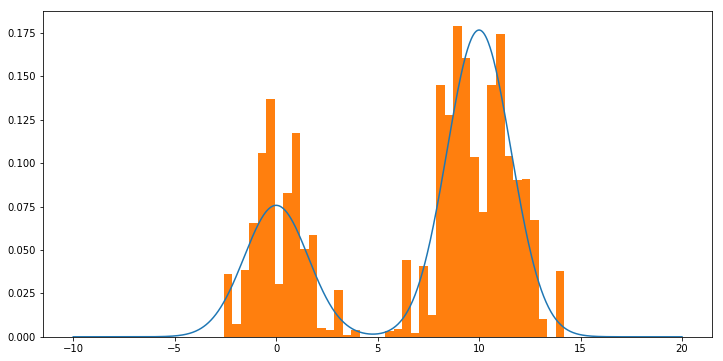

In [41]:
x = np.linspace(-10,20, 1000)
plt.plot(x,p(x)/normalized_factor[0])
plt.hist(samples, bins=40,normed=True);


## Gibbs sampling

Gibss sampling is an MCMC algorithm for obtaining approximate draws from a joint distribution, based on sampling from **conditional** distributions one at a time: at each stage, one variable is updated (keeping all other varibles fixed) by drawing from the condtional distributions of that variable given all other variables.

This approach is very useful when we have conditional distributions that are pleasant to work with.

We have to major Gibbs samplers:

1. Systematic scan Gibbs sampler: components (dimensions, variables) are updated one by one in order
2. Random scan Gibbs sampler: a randomly chosen component is update at each stag.

We illustrate Gibbs sampler in the context of bivariate $p(X,Y)$ and both $X, Y$ are discrete.


**Systematic scan Gibbs sampler**: Let X and Y be discrete r.v.s with joint PMF $p_{X,Y}(x,y) = p(X=x, Y=y)$. We wish to construct a two-dimensional Markov chain $(X_n, Y_n)$ whose stationary distribution is $p_{X,Y}$. If the current state is $(X_n, Y_n) = (x_n,y_n)$, then:

1. Draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1} = x_{n+1}$
2. Draw a value $y_{n+1}$ from the conditional distribution of Y given $X = x_{n+1}$, and set $Y_{n+1} = y_{n+1}$
3. Repeat step 1 and step 2 over and over, the stationary distribution of the chain $(X_0, Y_0),(X_1, Y_1), \dots$ is $p_{X,Y}$

**Random scan Gibbs sampler** The difference compared to systematic scan Gibbs sampler is that in each stage, it picks a unifomrly random component and updates it, according to the conditional distributions given the other component:

1. Choose which component to update, with equal probabilities.
2. If the X-coponent was chosen, draw a value $x_{n+1}$ from the conditional distribution of X given $Y = y_n$ and set $X_{n+1}= x_{n+1}, Y_{n+1} = y_n$. We do similar update if $Y_n$ is choosen to update.
3. Repeat steps 1 and 2 over and over, the stationary distribution of the chain $(X_0, Y_0), (X_1, Y_1), \dots$ is $p_{X,Y}$